In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, List
import pandas as pd
from tqdm import tqdm

# DL library imports
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn, optim
import torch.nn.functional as F

In [2]:
# Dataset: Fashion MNIST
dataset_labels = ['TShirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'AnkleBoot']

# necessary image transform i.e. convert to Tensor, normalize
train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)) ])
test_transform  = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)) ])

# Download the Train and Test set
train_set = datasets.FashionMNIST('.', train=True, download=True, transform=train_transform)
test_set = datasets.FashionMNIST('.', train=False, download=True, transform=test_transform)

In [3]:
NUM_WORKERS = 1 
TEST_BATCH_SIZE  = 64
TRAIN_BATCH_SIZE = 16
VALID_SIZE = 0.2 

In [4]:
len_train_set = len(train_set)
index_list = list(range(len_train_set))
np.random.shuffle(index_list)
split_index = int(len_train_set * VALID_SIZE)
train_idx, valid_idx = index_list[split_index:], index_list[:split_index]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [5]:
train_loader = DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE, sampler=train_sampler, num_workers=NUM_WORKERS)
valid_loader = DataLoader(train_set, batch_size=TEST_BATCH_SIZE,  sampler=valid_sampler, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_set,  batch_size=TEST_BATCH_SIZE,  shuffle=True,num_workers=NUM_WORKERS)

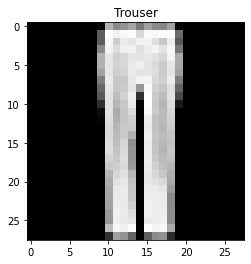

In [6]:
img, label = next(iter(train_loader))
plt.imshow(img[0].numpy().squeeze(), cmap = 'Greys_r')
plt.title(f'{dataset_labels[label[0].item()]}')
plt.show()

In [7]:
class MLPClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128, bias=True)
        self.fc2 = nn.Linear(128, 64, bias=True)
        self.fc3 = nn.Linear(64, 32, bias=True)
        self.fc4 = nn.Linear(32, 10, bias=True)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [8]:
# Load the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPClassifier().to(device)

In [9]:
from modelMetrics import computeInferenceTime, getModelFileSize, profile, getModelSize

def print_model_metrics(model, dummy_input):
  print("Model Size: ", str(round(getModelSize(model),3)),"Mb")
  print("File Size: ", str(round(getModelFileSize(model),3)),"Mb")
  print("Inference Time: ",str(round(computeInferenceTime(model,dummy_input, device),5)),"s")
  macs, params = profile(model, inputs=(dummy_input,), verbose=False)
  flops = 2 * macs
  print("Mega FLOPS: ", str(flops * 1e-6))
  print("Mega MACs: ", str(macs * 1e-6))
  print("Mega Params: ", str(params * 1e-6))


random_input = torch.rand(2, 28, 28).to(device)
print_model_metrics(model, random_input)

Model Size:  0.424 Mb
File Size:  0.447 Mb
Inference Time:  0.00396 s
Mega FLOPS:  0.443648
Mega MACs:  0.221824
Mega Params:  0.111146


In [10]:
def get_model_sparsity(model):
    totalElements = 0
    totalZeroElements = 0
    for name, module in model.named_children():
        numElementsInLayer = float(module.weight.nelement())
        numZeroElementsInLayer = float(torch.sum(module.weight == 0))
        layerWeightSparsity = 100.0 * (numZeroElementsInLayer/ numElementsInLayer)
        print(f"Sparsity in {name}.weight: {layerWeightSparsity}%.")
        
        totalElements += numElementsInLayer
        totalZeroElements += numZeroElementsInLayer
    
    if totalElements > 0 :
        globalWeightSparsity = 100.0 * (totalZeroElements / totalElements)
    else:
        globalWeightSparsity = 0.0
    return globalWeightSparsity
    
sparsity = get_model_sparsity(model)
print(f"Global Sparsity (weight): {sparsity}%")

Sparsity in fc1.weight: 0.0%.
Sparsity in fc2.weight: 0.0%.
Sparsity in fc3.weight: 0.0%.
Sparsity in fc4.weight: 0.0%.
Global Sparsity (weight): 0.0%


In [11]:
from sklearn.metrics import accuracy_score

class meanClassificationAccuracyMetric:
    """ Class to find the avg accuracy of softmax predictions to ground truth label """    
    def __init__(self):
        self.batchAccuracies = []
        self.meanClassificationAccuracy = 0.0

    def update(self, y_preds: torch.Tensor, labels: torch.Tensor):
        # predicted output class
        modelPredictions = np.argmax(torch.softmax(y_preds, axis=1).numpy(), axis=1)
        self.batchAccuracies.append(accuracy_score(labels.numpy(), modelPredictions))

    def compute(self):
        self.meanClassificationAccuracy = np.mean(self.batchAccuracies) * 100.0
        return self.meanClassificationAccuracy

In [12]:
def plotTrainingResults(df, model_name):
    fig, ax1 = plt.subplots(figsize=(10,4))
    ax1.set_ylabel('trainLoss', color='tab:red')
    ax1.plot(df['epoch'].values, df['trainLoss'].values, color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()  
    ax2.set_ylabel('validationLoss', color='tab:blue')
    ax2.plot(df['epoch'].values, df['validationLoss'].values, color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.suptitle(f'{model_name} Training, Validation Curves')
    plt.show()

In [13]:
def trainValidateModel(model, criterion, optimizer, dataloader_train, 
                       dataloader_valid, metricClass, metricName, device):
    results = []    
    min_val_loss = np.Inf
    len_train_loader = len(dataloader_train)

    # move model to target device
    model.to(device)
    
    for epoch in range(N_EPOCHS):
        print(f"Starting {epoch + 1} epoch ...")
        
        # Training
        model.train()
        train_loss = 0.0
        for i, (inputs, labels) in tqdm(enumerate(dataloader_train), total=len_train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)  

            # Forward pass
            y_preds = model(inputs)
            loss = criterion(y_preds, labels)
            train_loss += loss.item()
              
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() 
            
        # Validate
        model.eval()
        validation_loss = 0.0
        metric_object = metricClass()

        with torch.no_grad():
            for inputs, labels in dataloader_valid:
                inputs = inputs.to(device)
                labels = labels.to(device)                
                y_preds = model(inputs)
            
                # calculate loss
                loss = criterion(y_preds, labels)
                validation_loss += loss.item()

                # update batch metric information            
                metric_object.update(y_preds.cpu().detach(), labels.cpu().detach())

        # compute per batch losses, metric value
        train_loss = train_loss / len(dataloader_train)
        validation_loss = validation_loss / len(dataloader_valid)
        validationMetric = metric_object.compute()

        print(f'Epoch: {epoch+1}, trainLoss:{train_loss:6.5f}, validationLoss:{validation_loss:6.5f}, {metricName}:{validationMetric: 4.2f}%')
        
        # store results
        results.append({'epoch': epoch, 'trainLoss': train_loss, 
                        'validationLoss': validation_loss, f'{metricName}': validationMetric})
        
        # if validation loss has decreased, save model and reset variable
        if validation_loss <= min_val_loss:
            min_val_loss = validation_loss
            torch.save(model.state_dict(), "MLP.pt")

    # plot results
    results = pd.DataFrame(results)
    plotTrainingResults(results, "MLP")
    return results

Starting 1 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 303.16it/s]


Epoch: 1, trainLoss:0.67766, validationLoss:0.51953, accuracy: 81.31%
Starting 2 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:10<00:00, 297.08it/s]


Epoch: 2, trainLoss:0.55613, validationLoss:0.53007, accuracy: 82.11%
Starting 3 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:10<00:00, 290.48it/s]


Epoch: 3, trainLoss:0.53402, validationLoss:0.51950, accuracy: 82.81%
Starting 4 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:10<00:00, 290.01it/s]


Epoch: 4, trainLoss:0.52287, validationLoss:0.55881, accuracy: 81.35%
Starting 5 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 303.86it/s]


Epoch: 5, trainLoss:0.51510, validationLoss:0.56869, accuracy: 82.00%
Starting 6 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:10<00:00, 298.19it/s]


Epoch: 6, trainLoss:0.50845, validationLoss:0.60323, accuracy: 79.86%
Starting 7 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 303.08it/s]


Epoch: 7, trainLoss:0.50873, validationLoss:0.49915, accuracy: 84.13%
Starting 8 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:10<00:00, 297.05it/s]


Epoch: 8, trainLoss:0.50207, validationLoss:0.47608, accuracy: 84.09%
Starting 9 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 301.94it/s]


Epoch: 9, trainLoss:0.47911, validationLoss:0.51852, accuracy: 82.90%
Starting 10 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 320.05it/s]


Epoch: 10, trainLoss:0.48293, validationLoss:0.50265, accuracy: 83.75%
Starting 11 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:10<00:00, 294.58it/s]


Epoch: 11, trainLoss:0.51173, validationLoss:0.50683, accuracy: 82.67%
Starting 12 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 314.90it/s]


Epoch: 12, trainLoss:0.46797, validationLoss:0.47028, accuracy: 84.14%
Starting 13 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 314.53it/s]


Epoch: 13, trainLoss:0.50700, validationLoss:0.47267, accuracy: 84.82%
Starting 14 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 314.25it/s]


Epoch: 14, trainLoss:0.50583, validationLoss:0.56747, accuracy: 83.04%
Starting 15 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 317.20it/s]


Epoch: 15, trainLoss:0.48147, validationLoss:0.50347, accuracy: 83.64%
Starting 16 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 313.87it/s]


Epoch: 16, trainLoss:0.48044, validationLoss:0.59683, accuracy: 82.63%
Starting 17 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 318.05it/s]


Epoch: 17, trainLoss:0.52389, validationLoss:0.51472, accuracy: 84.07%
Starting 18 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 315.63it/s]


Epoch: 18, trainLoss:0.53075, validationLoss:0.52280, accuracy: 83.26%
Starting 19 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 313.76it/s]


Epoch: 19, trainLoss:0.49899, validationLoss:0.56375, accuracy: 83.45%
Starting 20 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 317.76it/s]


Epoch: 20, trainLoss:0.51298, validationLoss:0.58697, accuracy: 81.33%
Starting 21 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 321.17it/s]


Epoch: 21, trainLoss:0.48948, validationLoss:0.51636, accuracy: 83.96%
Starting 22 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 318.53it/s]


Epoch: 22, trainLoss:0.49101, validationLoss:0.52727, accuracy: 83.46%
Starting 23 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 313.67it/s]


Epoch: 23, trainLoss:0.48665, validationLoss:0.55171, accuracy: 82.89%
Starting 24 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 322.23it/s]


Epoch: 24, trainLoss:0.46798, validationLoss:0.52286, accuracy: 83.04%
Starting 25 epoch ...


100%|██████████████████████████████████████| 3000/3000 [00:09<00:00, 314.18it/s]


Epoch: 25, trainLoss:0.52972, validationLoss:1.05218, accuracy: 73.38%


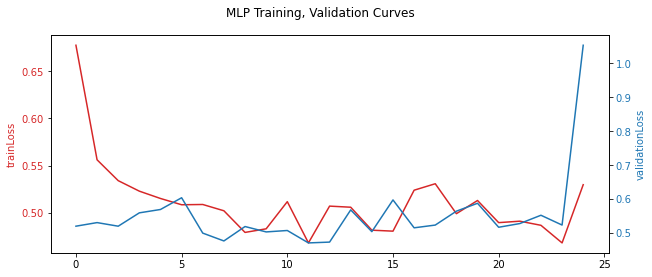

In [14]:
# Hyper parameters for training model
N_EPOCHS = 25
LR = 1e-2

# Define the Loss
criterion = nn.CrossEntropyLoss()

# Define the Optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

# train, validate standard model
modelResults = trainValidateModel(model, criterion, optimizer, train_loader, valid_loader, meanClassificationAccuracyMetric, 'accuracy', device)

In [15]:
def evaluteOnTestData(model, pretrainedModelPath, device, 
                     dataloader_test, metricClass, metricName, modelName):
    testSetMetric = 0.0
    if pretrainedModelPath is not None:
        if os.path.isfile(pretrainedModelPath) == True:
            model.load_state_dict(torch.load(pretrainedModelPath, map_location=device))

    model.to(device)
    model.eval()
    metricObject = metricClass()

    with torch.no_grad():
      for inputs, labels in tqdm(dataloader_test, total=len(dataloader_test)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_preds = model(inputs)
            
        # update batch metric information            
        metricObject.update(y_preds.cpu().detach(), labels.cpu().detach())

    testSetMetric = metricObject.compute()    
    print(f'\n{modelName} has {testSetMetric} {metricName} on testData')
    return testSetMetric

In [16]:
testSetMetric = evaluteOnTestData(model, "./MLP.pt", device, test_loader, 
                    meanClassificationAccuracyMetric, "Test_Accuracy", "Custom_MLP")

100%|████████████████████████████████████████| 157/157 [00:01<00:00, 103.76it/s]


Custom_MLP has 82.95183121019109 Test_Accuracy on testData


In [17]:
import torch.nn.utils.prune as prune

In [18]:
# Let's use different pruning percentages for each technique
prunePercentages = np.linspace(0.05, 0.90, 8).tolist()
print([round(x,3) for x in prunePercentages])

[0.05, 0.171, 0.293, 0.414, 0.536, 0.657, 0.779, 0.9]


In [19]:
def layer_unstructured_prune(model:nn.Module, prunePercentage:float):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=prunePercentage)
    return model

In [20]:
# placeholder to store results
l1_unstructured_accuracies = []

# iterate through each prune percentage
for perc in prunePercentages:
    # load the pretrained model
    model = MLPClassifier().to(device)
    model.load_state_dict(torch.load("./MLP.pt"))

    # prune the model
    unStructuredPruneModel = layer_unstructured_prune(model, perc)

    # evaluate the pruned model on test data
    l1_unstructured_accuracies.append(evaluteOnTestData(unStructuredPruneModel, None, \
          device, test_loader, meanClassificationAccuracyMetric, "Test accuracy", "Unstructured Prune"))    

100%|████████████████████████████████████████| 157/157 [00:01<00:00, 103.07it/s]



Unstructured Prune has 82.91202229299363 Test accuracy on testData


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 106.34it/s]



Unstructured Prune has 82.88216560509554 Test accuracy on testData


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 106.60it/s]



Unstructured Prune has 82.64331210191082 Test accuracy on testData


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 108.69it/s]



Unstructured Prune has 19.76512738853503 Test accuracy on testData


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 105.18it/s]



Unstructured Prune has 19.775079617834397 Test accuracy on testData


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 104.19it/s]



Unstructured Prune has 19.566082802547772 Test accuracy on testData


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 106.75it/s]



Unstructured Prune has 19.347133757961785 Test accuracy on testData


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 108.76it/s]


Unstructured Prune has 11.19625796178344 Test accuracy on testData


In [21]:
def layer_structured_prune(model:nn.Module, prunePercentage:float):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            prune.ln_structured(module, name='weight', amount=prunePercentage, n=1, dim=0)
    return model

In [22]:
# placeholder to store results
l1_structured_accuracies = []

# iterate through each prune percentage
for perc in prunePercentages:
    # load the pretrained model
    model = MLPClassifier().to(device)
    model.load_state_dict(torch.load("./MLP.pt"))

    # prune the model
    structuredPruneModel = layer_structured_prune(model, perc)

    # evaluate the pruned model on test data
    l1_structured_accuracies.append(evaluteOnTestData(structuredPruneModel, None, \
          device, test_loader, meanClassificationAccuracyMetric, "Test accuracy", "structured Prune"))

100%|████████████████████████████████████████| 157/157 [00:01<00:00, 107.88it/s]



structured Prune has 82.95183121019109 Test accuracy on testData


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 103.84it/s]



structured Prune has 71.90485668789809 Test accuracy on testData


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 105.92it/s]



structured Prune has 65.67476114649682 Test accuracy on testData


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 108.54it/s]



structured Prune has 61.236066878980886 Test accuracy on testData


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 106.78it/s]



structured Prune has 54.209792993630565 Test accuracy on testData


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 105.75it/s]



structured Prune has 25.895700636942674 Test accuracy on testData


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 105.35it/s]



structured Prune has 9.952229299363058 Test accuracy on testData


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 104.26it/s]


structured Prune has 9.982085987261147 Test accuracy on testData


In [23]:
def global_unstructured_prune(model:nn.Module, prunePercentage:float):
    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))
    prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=prunePercentage)
    return model

In [24]:
# placeholder to store results
global_prune_accuracies = []

# iterate through each prune percentage
for perc in prunePercentages:
    # load the pretrained model
    model = MLPClassifier().to(device)
    model.load_state_dict(torch.load("./MLP.pt"))

    # prune the model
    globalPruneModel = global_unstructured_prune(model, perc)

    # evaluate the pruned model on test data
    global_prune_accuracies.append(evaluteOnTestData(globalPruneModel, None, \
          device, test_loader, meanClassificationAccuracyMetric, "Test accuracy", "structured Prune"))    

100%|████████████████████████████████████████| 157/157 [00:01<00:00, 105.36it/s]



structured Prune has 83.07125796178345 Test accuracy on testData


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 105.42it/s]



structured Prune has 83.13097133757962 Test accuracy on testData


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 107.31it/s]



structured Prune has 82.71297770700637 Test accuracy on testData


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 108.61it/s]



structured Prune has 75.2687101910828 Test accuracy on testData


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 106.65it/s]



structured Prune has 19.745222929936308 Test accuracy on testData


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 109.21it/s]



structured Prune has 19.506369426751593 Test accuracy on testData


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 105.48it/s]



structured Prune has 22.91003184713376 Test accuracy on testData


100%|████████████████████████████████████████| 157/157 [00:01<00:00, 105.32it/s]


structured Prune has 10.011942675159236 Test accuracy on testData


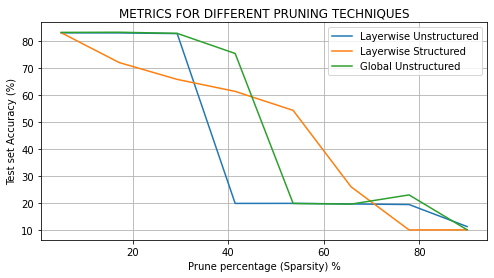

In [25]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(np.array(prunePercentages) * 100.0, np.array(l1_unstructured_accuracies), label='Layerwise Unstructured')
ax.plot(np.array(prunePercentages) * 100.0, np.array(l1_structured_accuracies), label='Layerwise Structured')
ax.plot(np.array(prunePercentages) * 100.0, np.array(global_prune_accuracies), label='Global Unstructured')
ax.set(xlabel ='Prune percentage (Sparsity) %', ylabel = 'Test set Accuracy (%)', title = 'METRICS FOR DIFFERENT PRUNING TECHNIQUES')
ax.legend()
ax.grid(True)
plt.show()

In [26]:
model = MLPClassifier().to(device)
model.load_state_dict(torch.load("./MLP.pt"))
print_model_metrics(unStructuredPruneModel, random_input)

Model Size:  0.847 Mb
File Size:  0.892 Mb
Inference Time:  0.00014 s
Mega FLOPS:  0.443648
Mega MACs:  0.221824
Mega Params:  0.111146


In [27]:
model = MLPClassifier().to(device)
model.load_state_dict(torch.load("./MLP.pt"))
unStructuredPruneModel = layer_unstructured_prune(model, 0.3)

print_model_metrics(unStructuredPruneModel, random_input)

Model Size:  0.847 Mb
File Size:  0.892 Mb
Inference Time:  0.00014 s
Mega FLOPS:  0.443648
Mega MACs:  0.221824
Mega Params:  0.111146


In [28]:
model = MLPClassifier().to(device)
model.load_state_dict(torch.load("./MLP.pt"))
StructuredPruneModel = layer_structured_prune(model, 0.1)

print_model_metrics(StructuredPruneModel, random_input)

Model Size:  0.847 Mb
File Size:  0.892 Mb
Inference Time:  0.00016 s
Mega FLOPS:  0.443648
Mega MACs:  0.221824
Mega Params:  0.111146


In [29]:
model = MLPClassifier().to(device)
model.load_state_dict(torch.load("./MLP.pt"))
globalPruneModel = global_unstructured_prune(model, 0.9414)

print_model_metrics(globalPruneModel, random_input)

Model Size:  0.847 Mb
File Size:  0.892 Mb
Inference Time:  0.00015 s
Mega FLOPS:  0.443648
Mega MACs:  0.221824
Mega Params:  0.111146


In [30]:
import matplotlib
import matplotlib.patches as mpatches

binary_cmap = matplotlib.colors.ListedColormap(['#3D99FF', '#7F7F7F'])
patchList = []
for lab,c in zip([False, True], ['#3D99FF', '#7F7F7F']):
    patchList.append(mpatches.Patch(color=c, label=lab))

def plot_tensor_mask(pt_tensor, ax=None):
  z_np = pt_tensor.detach().cpu().numpy()
  ln = ax.imshow(z_np, cmap = binary_cmap)
  ax.axis('off')
  return ln

In [31]:
def plot_custom_model(model, title=''):
  fig, axes = plt.subplots(1,4,figsize=(16, 4), gridspec_kw={'width_ratios': [7,5,3,1]})

  model_masks = dict(model.named_buffers())
  plot_tensor_mask(model_masks['fc1.weight_mask'], axes[0])
  plot_tensor_mask(model_masks['fc2.weight_mask'], axes[1])
  plot_tensor_mask(model_masks['fc3.weight_mask'], axes[2])
  plot_tensor_mask(model_masks['fc4.weight_mask'], axes[3])
  
  axes[0].set_title('FC Layer1')
  axes[1].set_title('FC Layer2')
  axes[2].set_title('FC Layer3')
  axes[3].set_title('FC Layer4')
  
  if title is not '':
    plt.suptitle(title)

<>:15: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:15: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_83572/3520770426.py:15: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if title is not '':


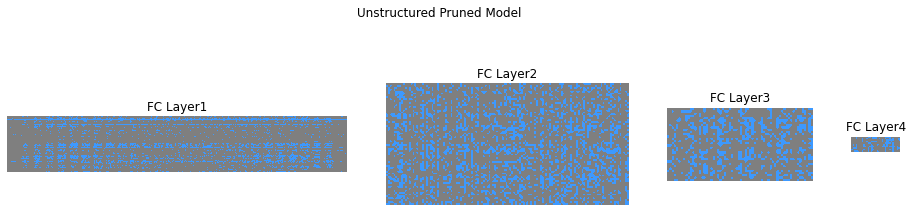

In [32]:
plot_custom_model(unStructuredPruneModel, title='Unstructured Pruned Model')